# Swift-Hohenberg equation tutorial

This is a simple tutorial to introduce you to the path continuation features of bice using the famous Swift-Hohenberg equation:

$\partial_t h = (r - (k_c^2 + \Delta)^2)h + v \, h^2 - g \, h^3$

With the parameters $r$, $k_c$, $v$, and $g$.

First, let's import the packages that we will need:

In [65]:
from IPython.display import display
import sys  # noqa
sys.path.append("../..")  # noqa
from bice.pde.finite_differences import *
import bice
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags
%matplotlib inline


Now, we can define the Swift-Hohenberg equation as a class:

In [66]:
class SwiftHohenbergEquation(FiniteDifferencesEquation):
    def __init__(self, N, L):
        super().__init__()
        # parameters
        self.r = -0.013
        self.kc = 0.5
        self.v = 0.41
        self.g = 1
        # spatial coordinate
        self.x = [np.linspace(-L/2, L/2, N)]
        # initial condition
        self.u = np.cos(2 * np.pi * self.x[0] / 10) * \
            np.exp(-0.005 * self.x[0] ** 2)
        # boundary conditions
        self.bc = PeriodicBC()
        # build finite difference matrices
        self.build_FD_matrices()
        # pre-compute linear operator
        laplace = self.laplace()
        self.linear_op = -2 * self.kc**2 * laplace - laplace.dot(laplace)

    # definition of the SHE (right-hand side)
    def rhs(self, u):
        return self.linear_op.dot(u) + (self.r - self.kc**4) * u + self.v * u**2 - self.g * u**3

    # definition of the Jacobian (not required, but more performant)
    def jacobian(self, u):
        return self.linear_op + diags(self.r - self.kc**4 + self.v * 2 * u - self.g * 3 * u**2)


A mathematical problem may consist of more than one equation. Hence, we need to set up a Problem and add the equation to it:

In [67]:

# create a problem
problem = bice.Problem()
# create instance of the equation and add it to the problem
she = SwiftHohenbergEquation(N=256, L=240)
problem.add_equation(she)

Let's visualize the initial condition:

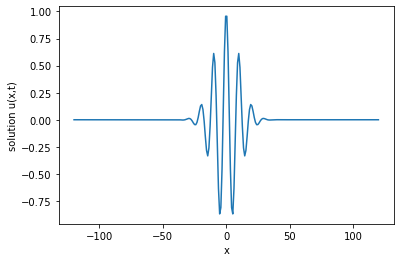

In [68]:
fig, ax = plt.subplots()
problem.plot(ax)

Next, we perform time-stepping until the solution has converged.

In this demo, we use a highly efficient BDF scheme of adaptive order and adaptive time step size, as implemented in `scipy.integrate.BDF`.

We check for convergence by taking the L²-norm of $\partial_t h$:

In [69]:
# initialize the time stepping scheme
problem.time_stepper = bice.time_steppers.BDF(problem)

n = 0
while np.linalg.norm(problem.rhs(problem.u)) > 1e-5:
    n += 1
    problem.time_step()
    dt = problem.time_stepper.dt
    print(f"Step #{n}, dt = {dt}")

Step #1, dt = 0.00037231604555307236
Step #2, dt = 0.00037231604555307236
Step #3, dt = 0.003723160455530724
Step #4, dt = 0.003723160455530725
Step #5, dt = 0.011973221934668168
Step #6, dt = 0.011973221934668168
Step #7, dt = 0.011973221934668168
Step #8, dt = 0.02491302584060446
Step #9, dt = 0.024913025840604466
Step #10, dt = 0.024913025840604466
Step #11, dt = 0.024913025840604466
Step #12, dt = 0.03680025480983992
Step #13, dt = 0.03680025480983992
Step #14, dt = 0.03680025480983992
Step #15, dt = 0.03680025480983995
Step #16, dt = 0.03680025480983995
Step #17, dt = 0.05538360358439648
Step #18, dt = 0.05538360358439648
Step #19, dt = 0.05538360358439648
Step #20, dt = 0.05538360358439648
Step #21, dt = 0.055383603584396424
Step #22, dt = 0.07580593944253333
Step #23, dt = 0.07580593944253333
Step #24, dt = 0.07580593944253333
Step #25, dt = 0.07580593944253333
Step #26, dt = 0.07580593944253333
Step #27, dt = 0.11371490393588257
Step #28, dt = 0.11371490393588246
Step #29, dt =

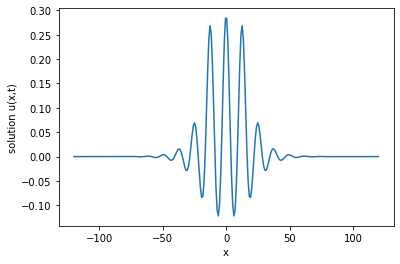

In [70]:
# Plot the solution
problem.plot(ax)
display(fig)

The solution has now converger to a steady state, which we can follow in the parameter space.

However, the solution is not unique, because it is invariant with respect to translation in $x$. Therefore, we add an additional equation to the problem, which is only satisfied when the solution of the SHE is right in the middle of the domain.

Such a constraint equation requires a few more lines of code. Luckily, it is already implemented in the bice package. We simply need to create the constraint equation, telling it which other equation to apply to, and add it to the problem!

In [71]:
# import the constraint
from bice.continuation import TranslationConstraint
# create a translation constraint for the SHE and add it to the problem
constraint = TranslationConstraint(she)
problem.add_equation(constraint)

Next, we can define the continuation parameter and perform a numerical continuation, much like we have performed the time simulation:

In [72]:
# define the continuation parameter by giving the
# reference to the equation and the parameter's name
problem.continuation_parameter = (she, "r")

# perform a few continuation steps
for n in range(15):
    problem.continuation_step()
    ds = problem.continuation_stepper.ds
    print(f"Step #{n}, ds = {ds:.2e}, r = {she.r}")


Step #0, ds = 1.00e-03, r = -0.012993094008801607
Step #1, ds = 1.00e-03, r = -0.012973370968048088
Step #2, ds = 1.10e-03, r = -0.01296132402147447
Step #3, ds = 1.21e-03, r = -0.012948135745242225
Step #4, ds = 1.33e-03, r = -0.012933709011661996
Step #5, ds = 1.46e-03, r = -0.012917942231180982
Step #6, ds = 1.61e-03, r = -0.012900730211506827
Step #7, ds = 1.77e-03, r = -0.012881965838113938
Step #8, ds = 1.95e-03, r = -0.012861542584701338
Step #9, ds = 2.14e-03, r = -0.012839358154539422
Step #10, ds = 2.36e-03, r = -0.012815319652603963
Step #11, ds = 2.59e-03, r = -0.012789350814721323
Step #12, ds = 2.85e-03, r = -0.012761401976298273
Step #13, ds = 3.14e-03, r = -0.012731463647136846
Step #14, ds = 3.14e-03, r = -0.012699584756094007


We see that the solution moves in parameter space! Let's visualize it.

Note that we now reserve space for 2x2 subplots to also see the bifurcation diagram, the eigenvalues and the most dominant eigenvector.

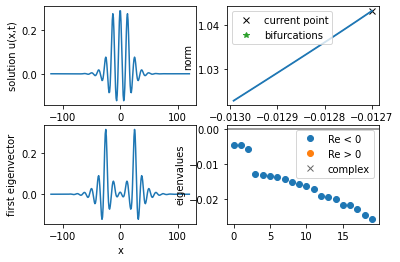

In [73]:
fig, ax = plt.subplots(2, 2)
problem.plot(ax)

If we continue the stepping, we can find a fold bifurcation, where the stability changes:

Step #0, ds = 3.14e-03, r = -0.01266889782937258
Step #1, ds = 3.14e-03, r = -0.012639492843774103
Step #2, ds = 3.14e-03, r = -0.012611456539621172
Step #3, ds = 3.14e-03, r = -0.012584872313105832
Step #4, ds = 3.14e-03, r = -0.012559819129069191
Step #5, ds = 3.14e-03, r = -0.012536370436884164
Step #6, ds = 3.45e-03, r = -0.012514593128383343
Step #7, ds = 3.45e-03, r = -0.012492638064930136
Step #8, ds = 3.45e-03, r = -0.012472843684402952
Step #9, ds = 3.45e-03, r = -0.0124552650896361
Step #10, ds = 3.45e-03, r = -0.01243994224567494
Step #11, ds = 3.45e-03, r = -0.01242690066921932
Step #12, ds = 3.45e-03, r = -0.012416151425281349
Step #13, ds = 3.45e-03, r = -0.012407691489419073
Step #14, ds = 3.45e-03, r = -0.012401504441856512
Step #15, ds = 3.45e-03, r = -0.012397561442044921
Step #16, ds = 3.45e-03, r = -0.012395822420734167
Step #17, ds = 3.45e-03, r = -0.012396237421480888
Step #18, ds = 3.45e-03, r = -0.012398748024270828
Step #19, ds = 3.80e-03, r = -0.01240328878951

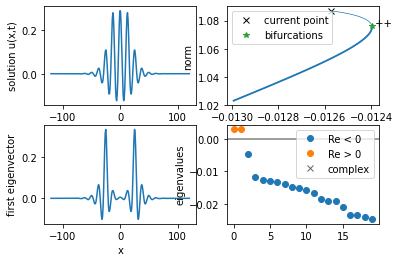

In [74]:

# perform a few continuation steps
for n in range(30):
    problem.continuation_step()
    ds = problem.continuation_stepper.ds
    print(f"Step #{n}, ds = {ds:.2e}, r = {she.r}")

# plot the diagram
problem.plot(ax)
display(fig)

The below code lists some notable properties of the continuation process that may be used to tweak the results

In [ ]:
# step size
problem.continuation_stepper.ds = 1e-3
# maximum step size
problem.continuation_stepper.ds_max = 1e-1
# number of eigenvalues to compute after each new step
problem.settings.neigs = 6
# locate bifurcations exactly using a bisection algorithm
problem.settings.always_locate_bifurcations = True

Bice can do much more to explore the parameter space of PDEs. Let's enjoy the features by automatically generating a full bifurcation diagram of the Swift-Hohenberg equation including switching to the ladder branches!

(Caution: this may take a while)

In [75]:

# automatically generate bifurcation diagram
problem.generate_bifurcation_diagram(parameter_lims=(-0.016, -0.012),
                                     max_recursion=0,
                                     max_steps=1e3)

# plot the diagram
problem.plot(ax)
display(ax)

Branch #8, Step #1, ds=4.59e-03, #+EVs: 2
Branch #8, Step #2, ds=4.59e-03, #+EVs: 2
Branch #8, Step #3, ds=4.59e-03, #+EVs: 2
Branch #8, Step #4, ds=5.05e-03, #+EVs: 2
Branch #8, Step #5, ds=5.05e-03, #+EVs: 2
Branch #8, Step #6, ds=5.05e-03, #+EVs: 2
Branch #8, Step #7, ds=5.56e-03, #+EVs: 2
Branch #8, Step #8, ds=5.56e-03, #+EVs: 2
Branch #8, Step #9, ds=6.12e-03, #+EVs: 2
Branch #8, Step #10, ds=6.73e-03, #+EVs: 2
Branch #8, Step #11, ds=6.73e-03, #+EVs: 2
Branch #8, Step #12, ds=7.40e-03, #+EVs: 2
Branch #8, Step #13, ds=8.14e-03, #+EVs: 2
Branch #8, Step #14, ds=8.95e-03, #+EVs: 2
Branch #8, Step #15, ds=8.95e-03, #+EVs: 2
Branch #8, Step #16, ds=9.85e-03, #+EVs: 2
Branch #8, Step #17, ds=1.08e-02, #+EVs: 2
Branch #8, Step #18, ds=1.19e-02, #+EVs: 2
Branch #8, Step #19, ds=1.31e-02, #+EVs: 2
Branch #8, Step #20, ds=1.31e-02, #+EVs: 2
Branch #8, Step #21, ds=1.31e-02, #+EVs: 2
Branch #8, Step #22, ds=1.31e-02, #+EVs: 2
Branch #8, Step #23, ds=1.31e-02, #+EVs: 2
Branch #8, Step #24,